<a href="https://colab.research.google.com/github/ConradBitt/processamento_linguagem_natural/blob/master/Word2vec_Treinando_word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução 

Este notebook tem como objetivo criar representações textuais através de **word2vec**, um classificador de títulos de reportagens de jornal. Posteriormente, após a representação, treino e teste do modelo, será disponibilizado através de uma aplicação web visando simular um ambiente de produção.

## Montando Drive

O motivo de usar o colaboratory é porque processamento de linguagem envolve muita memoria RAM e portanto rodar localmente pode se tonar um tanto custoso.Além disso, através do calab é permitido montar uma imagem do drive onde podemos armazenar os dados. Por esses dois motivos optei pelo google colab:


In [1]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib as mpl
import spacy


from matplotlib import pyplot as plt

sns.set_context('talk')

# Executar apenas uma vez e depois reiniciar o ambiente de execução.
!python -m spacy download pt_core_news_sm

print('~ Versões dos Módulos ~')
print(f'Pandas: {pd.__version__}')
print(f'Seaborn: {sns.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Matplotlib: {mpl.__version__}')
print(f'Spacy: {spacy.__version__}')

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
~ Versões dos Módulos ~
Pandas: 1.1.5
Seaborn: 0.11.1
Numpy: 1.19.5
Matplotlib: 3.2.2
Spacy: 2.2.4


# Lendo os dados

In [3]:
treino = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/treino.csv')
teste = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/word2vec/dados/teste.csv')

## Informações datasets

In [4]:
display(treino.info())
display(teste.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        90000 non-null  object
 1   text         90000 non-null  object
 2   date         90000 non-null  object
 3   category     90000 non-null  object
 4   subcategory  17175 non-null  object
 5   link         90000 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20513 entries, 0 to 20512
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        20513 non-null  object
 1   text         20513 non-null  object
 2   date         20513 non-null  object
 3   category     20513 non-null  object
 4   subcategory  6794 non-null   object
 5   link         20513 non-null  object
dtypes: object(6)
memory usage: 961.7+ KB


None

Temos: 
* 90000 observações nos dados de treino, totalizando 4.1MB.
* 20513 observações nos dados de teste, totalizando 961KB

todos os dados são do tipo object, porvavelmente strings dividos em 6 variaveis, `titulo`, `text`, `date`, `category`, `subcategory`, `link`.

## Exibindo alguns dados

In [5]:
treino.head()

,title,text,date,category,subcategory,link
0,"Após polêmica, Marine Le Pen diz que abomina n...",A candidata da direita nacionalista à Presidên...,2017-04-28,mundo,NaN,http://www1.folha.uol.com.br/mundo/2017/04/187...
1,"Macron e Le Pen vão ao 2º turno na França, em ...",O centrista independente Emmanuel Macron e a d...,2017-04-23,mundo,NaN,http://www1.folha.uol.com.br/mundo/2017/04/187...
2,"Apesar de larga vitória nas legislativas, Macr...",As eleições legislativas deste domingo (19) na...,2017-06-19,mundo,NaN,http://www1.folha.uol.com.br/mundo/2017/06/189...
3,"Governo antecipa balanço, e Alckmin anuncia qu...",O número de ocorrências de homicídios dolosos ...,2015-07-24,cotidiano,NaN,http://www1.folha.uol.com.br/cotidiano/2015/07...
4,"Após queda em maio, a atividade econômica sobe...","A economia cresceu 0,25% no segundo trimestre,...",2017-08-17,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/08/1...


Usaremos a variável ``title`` para tentar estimar a variável ``category``. Entretanto, vamos analisar como é apresentada uma observação:


In [6]:
treino.title.iloc[-10]

'Pagamento de propina pode chegar a R$ 50 mil por carga'

perceba que temos palavras, números e caracteres especiais "\$", então é necessário um pré processamento.

# Pre processamento 

Geralmente se utiliza o NLTK para fazer a filtragem de caracteres e tokenização. Neste notebook vou utilizar o [spaCy](https://spacy.io/) um módulo escrito em  Python e Cython para processamento de linguagem natural.

A documentação esta disponível em: 

> https://spacy.io/api



## Instalando SpaCy

Para instalar o SpaCy segue-se as instruções no site:

> https://spacy.io/usage

Entretanto no colab ele já vem instalado por padrão

O que precisamo fazer é baixar a lingua cujo os nossos dados foram escritos, no mesmo site tem as linhas que devem ser executadas para instalar o idioma portguês:

In [7]:
# Executar apenas uma vez e depois reiniciar o ambiente de execução.
#!python -m spacy download pt_core_news_sm

Para testar se o idioma desejado foi instalado executamos o comando. **Depois de baixar os dados é necessário reiniciar o ambiente de execução.**

In [8]:
nlp = spacy.load('pt_core_news_sm')

### Exemplo de uso

In [9]:
meu_texto = treino.title.iloc[22]
print(meu_texto)

doc = nlp(meu_texto)
print(type(doc))

Jon Snow volta aos holofotes em vídeo da 6ª temporada de 'Game of Thrones'
<class 'spacy.tokens.doc.Doc'>


Note que o nlp tem objetos do tipo ``Doc``, para saber o que esse objeto contém, podemos analisar a documentação:

> https://spacy.io/usage/spacy-101#pipelines

A descrição do Doc é: 

> A Doc is a sequence of Token objects. Access sentences and named entities, export annotations to numpy arrays, losslessly serialize to compressed binary strings. The Doc object holds an array of TokenC structs. The Python-level Token and Span objects are views of this array, i.e. they don’t own the data themselves. Fonte: [https://spacy.io/api/doc](https://spacy.io/api/doc)

Basicamente quando instanciamos um objeto ``Doc`` o ``nlp`` faz uma série de processamentos, como tokenização, targge, parser, entre outros, até criar o objeto.

<img src='https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg' width=80%>

> Fonte: https://spacy.io/usage/spacy-101#pipelines

Os objetos ``Doc`` tem atributos muito uteis, podemos consultar em

> https://spacy.io/api/doc


In [10]:
print('Meu Doc: ', doc)
print('Entidades de doc: ', doc.ents)


Meu Doc:  Jon Snow volta aos holofotes em vídeo da 6ª temporada de 'Game of Thrones'
Entidades de doc:  (Jon Snow, Game of Thrones)


O objeto consegue identificar varias classificações dos elementos que compõem a frase

In [11]:
print(doc.text, '\n')
for token in doc:
    print(token.text, token.pos_, token.dep_)

Jon Snow volta aos holofotes em vídeo da 6ª temporada de 'Game of Thrones' 

Jon PROPN nsubj
Snow PROPN flat:name
volta VERB ROOT
a ADP case
os DET det
holofotes PROPN obl
em ADP case
vídeo NOUN obl
da ADP case
6ª ADJ amod
temporada NOUN nmod
de ADP case
' PUNCT punct
Game PROPN nmod
of PROPN flat:name
Thrones PROPN flat:name
' PUNCT punct


é possível utilizar varios métodos dos tokens, por exemplo a representação da palavra em um espaço vetorial:

In [12]:
print(doc[1], '=', doc[1].vector)

print('\nNorma do vetor')
print(doc[1], '=', doc[1].vector_norm)

Snow = [  2.7633104    7.462899     0.63145417   0.7640705    1.4044249
   1.0847819   -5.712425    -2.5970128    3.591257     6.957478
  11.282299     1.5133985   -5.667033    -1.6723096   -0.7537353
  -1.4369892   -2.0909038    0.29047918   4.8055325   -4.069366
  -3.749087    -1.4293463   -2.5723786    0.60486764  -4.8334146
  -7.603295     0.38302672  -3.394683    -1.864464    -7.2505016
  -2.334701    -5.8551       7.2367682    3.8455513    1.262495
 -10.394055     3.4092844   -4.875017     0.09814078   5.481478
   1.432259    -1.1912625   -7.294257    -2.0385437   -1.3923185
  -0.9888474   -4.113654     2.6139627   -1.9440972    3.370472
  -3.3382788   -8.765093     0.6188494    2.0189853   -7.73819
   9.392529     0.10228646   2.750429     1.814964    -2.7373686
  -1.5277661   -2.0538282    9.940031    -1.2688947    6.332727
  -8.138163     2.3974452   -0.10324526  -2.9152355   -0.81570804
   2.6807451   -5.3069367    4.2606955   -7.808796    -0.45525482
   2.3871043    1.440799

Podemos fazer análise de sentimento em relação ao ``token``:

> ``sentiment``	A scalar value indicating the positivity or negativity of the token. ``float``

In [13]:
for token in doc:
  print(token.sentiment)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


existem varios outros atributos e métodos disponíveis para tokens, disponíveis na documentação:

> https://spacy.io/api/token
  

## Algumas modificações e Generator Expression

Precisamos dos títulos tratados adequadamente para ser utilizados em modelos. Para isso é necessario uma função que faça essa modificação.

Antes disso vou deixar todos os dados em minusculo pois não faz diferença entre "comissão" e "Comissão".

> **Em vez de usar list comprehensions utilizarei um gerador criado através do generator expression. Basicamente cria um gerador para ser utilizado em tempo de execução. Para saber mais: [List Comprehension vs Generator Expressions in Python](https://code-maven.com/list-comprehension-vs-generator-expression)**

In [14]:

texto_para_tratamento = (titulo.lower() for titulo in treino.title)
print(f'O gerador: {texto_para_tratamento}')

O gerador: <generator object <genexpr> at 0x7f629f24c9d0>


em vez de receber um gerador a função para tratar os textos vai receber um ``Doc`` para conseguirmos realizar as seguintas rotinas:

* Remover stopwords "O, A, do, da, na, se, aqueles", palavras irrelevantes para entender o contexto.

* Ter apenas caracteres alphabeticos 

* Título com no mínomo três palavras.

In [15]:
def trata_textos(doc):
  """
  Esta função trata os textos recebidos,
  remove stopwords, retorna alphanumericos
  maior que três palavras.
  """
  tokens_validos = []
  for token in doc: 
    # variável de validação
    # garante que o token não é stopword e é alphanumerico
    e_valido = not token.is_stop and token.is_alpha
    if e_valido:
      tokens_validos.append(token.text)
      
  if len(tokens_validos) > 2:
    return " ".join(tokens_validos)

Testando a função:

In [16]:
print(doc)
trata_textos(doc)

Jon Snow volta aos holofotes em vídeo da 6ª temporada de 'Game of Thrones'


'Jon Snow volta a holofotes vídeo temporada Game of Thrones'

Um ponto importante é que o ``doc`` que criamos recebeu uma ``string``, mas precisamos passar uma estrtura de dados para ``nlp``, para saber como fazer isso precisamos entender como funciona a classe ``nlp``:

In [17]:
type(nlp)

spacy.lang.pt.Portuguese

Olhando a [documentação do ``spacy.lang``](https://spacy.io/api/language#init) um dos parâmetros utilizados pelo ``__init__()`` é o ``batch_size`` e para passar uma estrutura de dados com textos para o ``nlp`` utiliza-se um "pipeline" uma linha de processos, o seguinte exemplo ilustra como fazer isso: 

```python
texts = ["One document.", "...", "Lots of documents"]
for doc in nlp.pipe(texts, batch_size=50):
    assert doc.has_annotation("DEP")
```

Além do ``batch_size`` passado ao  ``nlp.pipe``, podemos dizer quantos batchs serão processados por cada núcleo através do parâmetro ``n_processor`` descrito na documentação do pipe:

> https://spacy.io/api/language#pipe

> ``n_process`` 	Number of processors to use. Defaults to 1.
int

para ver quantos núcleos de processamento a máquina virtual do colab basta usar o comando
> ``lscpu | grep -E '^Thread|^Core|^Socket|^CPU\('``

In [18]:
!lscpu | grep -E '^Thread|^Core|^Socket|^CPU\('

CPU(s):              2
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1


caso não saiba quantos núcleos de processamento tem, é possível passar ``n_process=-1`` ai o spacy irá utilizar todos os disponíveis.

### <font color=red ><b>Lembrando que esse processo pode demorar!</b></font>

```python
>>> texto_tratado = [trata_textos(doc) for doc in nlp.pipe(texto_para_tratamento,batch_size=1000,n_process = -1)]

CPU times: user 1h 54min 5s, sys: 1min 22s, total: 1h 55min 28s
Wall time: 2h 1min 1s
```

In [19]:
#texto_tratado = [trata_textos(doc) for doc in nlp.pipe(texto_para_tratamento,batch_size=1000,n_process = -1)]


### Salvando objeto
vou salvar est objeto para evitar que demore todo este tempo toda vez que for necessario executar este notebook:


```python
import pickle

file_texto_tratado = open(b'texto_tratado.obj','wb')
pickle.dump(texto_tratado, file_texto_tratado)

```

### Lendo objeto salvo

para ler o objeto salvo através do pickle, usamos a seguinte sintaxe, depois de baixar o arquivo:

https://github.com/ConradBitt/processamento_linguagem_natural/blob/master/texto_tratado.obj


In [20]:
import pickle

texto_tratado_objeto = open(b'/content/drive/MyDrive/Colab Notebooks/word2vec/dados/texto_tratado.obj',
                            'rb')
titulos_tratados = pickle.load(texto_tratado_objeto)

In [21]:
titulos_tratados[:15]

['ataques multiplicam israel e cisjordânia morrem gaza',
 'dutra trânsito lento chegada a paulo',
 'alta chicago bulls felício destaque brasil nba',
 'sábato influenciou críticos hoje questionado',
 'diretor israelense humor superar a dor perda shivá',
 'continuação universidade columbia analisa erros rolling stone reportagem',
 'el niño trará impactos enormes alertam cientistas',
 'folha lança aplicativo realidade virtual filme percorre sp',
 'platini suspensão fraude e promete recorrer uefa francês',
 'premiê israel pressionado a cancelar visita donald trump',
 None,
 'grêmio chega a acordo barrios e espera liberação palmeiras',
 'perspectivas abrem o mercosul',
 'governo campanha prevenção a hiv aplicativo gay',
 'brilho eterno mente lembranças terá série tv site']

> **Referência**: https://www.greelane.com/pt/ci%C3%AAncia-tecnologia-matem%C3%A1tica/ci%C3%AAncia-da-computa%C3%A7%C3%A3o/using-pickle-to-save-objects-2813661

## Tratando entradas 

In [22]:
titulos_tratados = pd.DataFrame(
    {'titulo':titulos_tratados}
)

titulos_tratados.head(15)

,titulo
0,ataques multiplicam israel e cisjordânia morre...
1,dutra trânsito lento chegada a paulo
2,alta chicago bulls felício destaque brasil nba
3,sábato influenciou críticos hoje questionado
4,diretor israelense humor superar a dor perda s...
5,continuação universidade columbia analisa erro...
6,el niño trará impactos enormes alertam cientistas
7,folha lança aplicativo realidade virtual filme...
8,platini suspensão fraude e promete recorrer ue...
9,premiê israel pressionado a cancelar visita do...


# Treinando modelo Gensim

Gensim é uma biblioteca com vários modelos já treinados onde só precisamos importar. A utilidade dela é que, assim só o fato de demorar 1h 50m pra seprar os dados, treinar o modelo também demora, então o gesim oferecendo modelos treinados onde só precisamos ajustar os nossos dados facilita muito.

> https://radimrehurek.com/gensim/

Sobre o modelo que vamos utilizar o Word2Vec o google tem um resumo de como ele funciona: 

> https://code.google.com/archive/p/word2vec/

mas basicamente ele representa palavras como vetores pertencentes à um espaço vetorial de dimensão finita.

Na documentação do Gensim podemos ver como esta classe funciona:

> https://radimrehurek.com/gensim/models/word2vec.html

In [23]:
from gensim.models import Word2Vec

Existem duas formas de resolver problemas de NLP com o Word2vec, através das CBOW e do SG. O Continous Bag Of Words (CBOW) tenta estimar uma palavra através do contexto, já o SkipGram (SG) tenta estimar o contexto através de uma palavra.

Para utilizar o SkipGram o parâmetro  ``sg = 1``, caso precisemos utilizar o CBOW ``sg = 0``.

Além disso, o fato dos algorítmos baseados em word2vec trabalhar com contexto precisamos dizer a "janela" de palavras utilizadas, ou ``window``.

Por fim, precisamos especificar o tamanho do vetor, isto é, o espaço vetorial em que o modelo irá trabalhar. Fazemos isso através do parâmetro ``size``.

Outro problema que podemos solucionar já na definição de hiperparâmetros são erros de digitação, por exemplo "escols"/"escoka"/"escolq", essas palavras são bem rara, então podemos definir uma frequência minima para que a palavra seja considerada pelo modelo. Por exemplo, ao settar ``min_count=5`` palavras que foram escritas menos de 5 vezes não serão consideradas. 

Outro parâmetro importante é o ``ALPHA``. Word2vec não é um modelo de rede profunda, mas tem um parâmetro de taxa de aprendizagem indicado por ``alpha``. Basicamente queremos minimizar a função de custo e o alpha é o coeficiente angular do gradiente desse campo que queremos minimizar. Mas pode acontecer desta função nunca atingir um minimo global, para ajudar neste problema é comum adicionar um decaimento no parâmetro alpha, através do ``min_alpha``

In [24]:
w2v_modelo = Word2Vec(sg = 0, window = 2,
                      size = 300, min_count=3,
                      alpha=0.03, min_alpha=0.007)

podemos salvar o modelo através do método: ``save()``:

In [25]:
#w2v_modelo.save("word2vec.model")

Instanciado o modelo precisamos criar um vocabulário e pra isso usamos uma [função do proprio word2vec para criar um vocabulario, chamada ``build_vocab``](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.build_vocab)

Mas pra isso é preciso garantir que não tenha palavras duplicadas e nem campos do tipo ``None``

In [26]:
print(titulos_tratados.shape)

titulos_tratados = titulos_tratados.dropna().drop_duplicates()

print(titulos_tratados.shape)

(86000, 1)
(82296, 1)


In [27]:
%%time
lista_de_lista_de_tokens = [titulo.split(' ') for titulo in titulos_tratados.titulo]

CPU times: user 300 ms, sys: 56.9 ms, total: 357 ms
Wall time: 380 ms


In [28]:
lista_de_lista_de_tokens[:5]

[['ataques', 'multiplicam', 'israel', 'e', 'cisjordânia', 'morrem', 'gaza'],
 ['dutra', 'trânsito', 'lento', 'chegada', 'a', 'paulo'],
 ['alta', 'chicago', 'bulls', 'felício', 'destaque', 'brasil', 'nba'],
 ['sábato', 'influenciou', 'críticos', 'hoje', 'questionado'],
 ['diretor', 'israelense', 'humor', 'superar', 'a', 'dor', 'perda', 'shivá']]

Dado que temos nossa lista com a lista de tokens de cada frase podemos fornecer ao modelo para que ele tenha um vocabulário:

In [29]:
import logging

logging.basicConfig(format='%(asctime)s : - %(message)s', level = logging.INFO)
w2v_modelo.build_vocab(lista_de_lista_de_tokens, progress_per=5000)

2021-05-09 16:40:46,618 : - collecting all words and their counts
2021-05-09 16:40:46,621 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-09 16:40:46,651 : - PROGRESS: at sentence #5000, processed 34585 words, keeping 10280 word types
2021-05-09 16:40:46,668 : - PROGRESS: at sentence #10000, processed 69086 words, keeping 14900 word types
2021-05-09 16:40:46,694 : - PROGRESS: at sentence #15000, processed 103768 words, keeping 18253 word types
2021-05-09 16:40:46,715 : - PROGRESS: at sentence #20000, processed 138486 words, keeping 21018 word types
2021-05-09 16:40:46,732 : - PROGRESS: at sentence #25000, processed 173220 words, keeping 23413 word types
2021-05-09 16:40:46,753 : - PROGRESS: at sentence #30000, processed 207734 words, keeping 25392 word types
2021-05-09 16:40:46,778 : - PROGRESS: at sentence #35000, processed 242400 words, keeping 27279 word types
2021-05-09 16:40:46,802 : - PROGRESS: at sentence #40000, processed 277127 words, keeping 2898

### Comentario sobre Word2vec

Os modelos de representações de palavras em espaços vetoriais que, de certa forma, capturam o contexto das frases proporcionaram um grande avanço na área de processamento de linguagem natural.

O artigo original de Tomas Mikolov, Kai Chen, Greg Corrado e Jeffrey Dean é o que descreveu como funciona o word2vec nas formas de CBOW e SG, [Efficient Estimation of Word Representations inVector Space](https://arxiv.org/pdf/1301.3781.pdf).

Existe também uma representação de word embedding feita pelo [Word Embedding Project Tensor Flow](https://projector.tensorflow.org/) onde ele representa em três dimensões essas palavras representadas em milhares de dimensões.

# Treinando modelo com word2vec

O nosso modelo em ``w2v_modelo`` tem vários atributos, podemos verificar quais são na documentação do Gensim, ou utilizar o método ``dir(w2v_modelo)``, ele vai indicar todos os atributos e métodos do objeto.

Vamos fazer um filtro para que sejam exibidos apenas os métodos e atributos publicos:

In [44]:
i = 1
for atributo in dir(w2v_modelo):
  if '_' not in atributo:
    print(f'{i} - {atributo}')
    i += 1
    
  
    

1 - accuracy
2 - alpha
3 - callbacks
4 - epochs
5 - hashfxn
6 - hs
7 - iter
8 - load
9 - negative
10 - random
11 - sample
12 - save
13 - score
14 - sg
15 - similarity
16 - syn1
17 - syn1neg
18 - train
19 - trainables
20 - vocabulary
21 - window
22 - wmdistance
23 - workers
24 - wv


note que o atributo nº 18 é ``train``, vamos utiliza-lo para treinar o modelo.

## Usando método ``train``:

```python 
Word2Vec.train(sentences=None, corpus_file=None, total_examples=None, total_words=None, 
  epochs=None, start_alpha=None, end_alpha=None, 
  word_count=0, queue_factor=2, report_delay=1.0, 
  compute_loss=False, callbacks=())
```

precisamos fornecer as sentenças/textos para o modelo e também a quantidade de amostras, mas sem dúvidas o parâmetro mais importante é o ``epochs``. Epocas é quando ocorre o foward e o backpropagation na rede para ajustar o peso da loss escolhida.

In [47]:
total_amostras = w2v_modelo.corpus_count
total_amostras

82296

In [49]:
%%time

w2v_modelo.train(sentences = lista_de_lista_de_tokens,
                 total_examples = total_amostras, 
                 epochs = 30)

2021-05-09 17:02:22,468 : - training model with 3 workers on 17867 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=2
2021-05-09 17:02:23,492 : - EPOCH 1 - PROGRESS: at 63.05% examples, 310753 words/s, in_qsize 5, out_qsize 0
2021-05-09 17:02:23,977 : - worker thread finished; awaiting finish of 2 more threads
2021-05-09 17:02:23,989 : - worker thread finished; awaiting finish of 1 more threads
2021-05-09 17:02:24,000 : - worker thread finished; awaiting finish of 0 more threads
2021-05-09 17:02:24,003 : - EPOCH - 1 : training on 571354 raw words (497533 effective words) took 1.5s, 327472 effective words/s
2021-05-09 17:02:25,033 : - EPOCH 2 - PROGRESS: at 59.58% examples, 291707 words/s, in_qsize 4, out_qsize 1
2021-05-09 17:02:25,611 : - worker thread finished; awaiting finish of 2 more threads
2021-05-09 17:02:25,628 : - worker thread finished; awaiting finish of 1 more threads
2021-05-09 17:02:25,645 : - worker thread finished; awaiting finish of 0 more t

CPU times: user 1min 23s, sys: 458 ms, total: 1min 24s
Wall time: 45.4 s


(14921120, 17140620)

# Analise dos resultados

Uma forma qualitativa de analisar o quanto um modelo consegue retornar palavras dado um contexto, por exemplo, executar a função ``most_similar`` que vai retornar palavras similares, outras [funções relacionadas ao modelo Word2Vec podem ser consultadas aqui.](https://radimrehurek.com/gensim/models/word2vec.html)

> ```word2vec.wv.most_similar(self, positive=None, negative=None, topn=10, restrict_vocab=None, indexer=None)```

In [54]:
w2v_modelo.wv.most_similar('google')

[('apple', 0.5987163782119751),
 ('facebook', 0.5933940410614014),
 ('software', 0.5381422638893127),
 ('uber', 0.5240345597267151),
 ('fbi', 0.5056719779968262),
 ('walmart', 0.5000754594802856),
 ('amazon', 0.48762497305870056),
 ('pfizer', 0.47581690549850464),
 ('waze', 0.46921342611312866),
 ('web', 0.46909794211387634)]

Note que dado uma empresa de tecnologia o modelo informa outras similares... 


In [58]:
w2v_modelo.wv.most_similar('microsoft',topn=20)

[('unilever', 0.6181350946426392),
 ('tesla', 0.6087472438812256),
 ('sky', 0.569259524345398),
 ('amazon', 0.5667519569396973),
 ('xiaomi', 0.565727949142456),
 ('lego', 0.5621176958084106),
 ('ikea', 0.5618140697479248),
 ('macy', 0.5590704679489136),
 ('editora', 0.5585172772407532),
 ('braskem', 0.5517585277557373),
 ('samsung', 0.5458100438117981),
 ('mastercard', 0.5451661348342896),
 ('canais', 0.5381833910942078),
 ('rangers', 0.5374184846878052),
 ('walmart', 0.5355345010757446),
 ('pfizer', 0.5349343419075012),
 ('disney', 0.534634530544281),
 ('rowling', 0.5330201983451843),
 ('inbev', 0.5292022228240967),
 ('sony', 0.5270721912384033)]


Note que por exemplo se usamos a palavra ``microsoft``, as palavras de contexto similar são empresas que compõem o [S&P 500](https://blog.clear.com.br/sp-500/). Podemos testar a palvra cujo contexto seja, um jogador de futebol específico, por exemplo *Messi*:

In [59]:
w2v_modelo.wv.most_similar('messi',topn=20)

[('suárez', 0.6332441568374634),
 ('cristiano', 0.5682059526443481),
 ('cavani', 0.5486650466918945),
 ('neymar', 0.5426616668701172),
 ('tevez', 0.538060188293457),
 ('enrique', 0.5369131565093994),
 ('barça', 0.5304419994354248),
 ('mordida', 0.5143275260925293),
 ('ronaldo', 0.504108726978302),
 ('benzema', 0.5031008720397949),
 ('psg', 0.501209020614624),
 ('maradona', 0.49990254640579224),
 ('pelé', 0.49308621883392334),
 ('chuteiras', 0.49238651990890503),
 ('buffarini', 0.47682374715805054),
 ('felipão', 0.47681134939193726),
 ('barcelona', 0.4688522219657898),
 ('inglaterra', 0.46605291962623596),
 ('chelsea', 0.4641041159629822),
 ('mourinho', 0.4588797092437744)]

as palavras relacionadas a messi realmente estão dentro do contexto de futebol internacional.

In [199]:
w2v_modelo.wv.most_similar('conrado')

[('amarrado', 0.6163891553878784),
 ('envelheço', 0.6146823167800903),
 ('samurai', 0.6025504469871521),
 ('itaim', 0.6022329330444336),
 ('camões', 0.596960186958313),
 ('miliciano', 0.5942776203155518),
 ('personal', 0.5924962162971497),
 ('pichar', 0.5875481367111206),
 ('diarista', 0.5863578915596008),
 ('palace', 0.5837728977203369)]

É importante salientar que as informações decorrem diretamente das caracteristicas do modelo que foi instanciado, logo caso sejam instanciados novos hiperparâmetros os resultados podem ser diferentes.

```python 
w2v_modelo = Word2Vec(sg = 0, window = 2,
                      size = 300, min_count=3,
                      alpha=0.03, min_alpha=0.007)
```

Vamos alterar alguns desses hiperparâmetros, por exemplo, em vez de usar o CBOW vamos usar o SG:

In [214]:
w2v_modelo = Word2Vec(sg = 1, window = 2,
                      size = 300, min_count=3,
                      alpha=0.03, min_alpha=0.007)

import logging
logging.basicConfig(format='%(asctime)s : - %(message)s', level = logging.INFO)
w2v_modelo.build_vocab(lista_de_lista_de_tokens, progress_per=5000)

2021-05-09 19:36:04,137 : - collecting all words and their counts
2021-05-09 19:36:04,139 : - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-05-09 19:36:04,152 : - PROGRESS: at sentence #5000, processed 34585 words, keeping 10280 word types
2021-05-09 19:36:04,166 : - PROGRESS: at sentence #10000, processed 69086 words, keeping 14900 word types
2021-05-09 19:36:04,180 : - PROGRESS: at sentence #15000, processed 103768 words, keeping 18253 word types
2021-05-09 19:36:04,196 : - PROGRESS: at sentence #20000, processed 138486 words, keeping 21018 word types
2021-05-09 19:36:04,209 : - PROGRESS: at sentence #25000, processed 173220 words, keeping 23413 word types
2021-05-09 19:36:04,227 : - PROGRESS: at sentence #30000, processed 207734 words, keeping 25392 word types
2021-05-09 19:36:04,243 : - PROGRESS: at sentence #35000, processed 242400 words, keeping 27279 word types
2021-05-09 19:36:04,261 : - PROGRESS: at sentence #40000, processed 277127 words, keeping 2898

In [215]:
%%time
w2v_modelo.train(sentences = lista_de_lista_de_tokens,
                 total_examples = total_amostras, 
                 epochs = 30)

2021-05-09 19:36:08,209 : - training model with 3 workers on 17867 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=2
2021-05-09 19:36:09,229 : - EPOCH 1 - PROGRESS: at 33.29% examples, 163856 words/s, in_qsize 6, out_qsize 0
2021-05-09 19:36:10,244 : - EPOCH 1 - PROGRESS: at 75.27% examples, 184801 words/s, in_qsize 5, out_qsize 0
2021-05-09 19:36:10,694 : - worker thread finished; awaiting finish of 2 more threads
2021-05-09 19:36:10,733 : - worker thread finished; awaiting finish of 1 more threads
2021-05-09 19:36:10,743 : - worker thread finished; awaiting finish of 0 more threads
2021-05-09 19:36:10,745 : - EPOCH - 1 : training on 571354 raw words (497268 effective words) took 2.5s, 196936 effective words/s
2021-05-09 19:36:11,770 : - EPOCH 2 - PROGRESS: at 35.06% examples, 173429 words/s, in_qsize 5, out_qsize 0
2021-05-09 19:36:12,807 : - EPOCH 2 - PROGRESS: at 73.52% examples, 179121 words/s, in_qsize 5, out_qsize 0
2021-05-09 19:36:13,402 : - worker 

CPU times: user 2min 17s, sys: 600 ms, total: 2min 18s
Wall time: 1min 13s


(14920231, 17140620)

In [216]:
w2v_modelo.wv.most_similar('google', topn=20)

2021-05-09 19:37:21,279 : - precomputing L2-norms of word weight vectors


[('alphabet', 0.4810846447944641),
 ('apple', 0.46528828144073486),
 ('reguladores', 0.46264079213142395),
 ('foxconn', 0.44449615478515625),
 ('iphones', 0.43887168169021606),
 ('snapchat', 0.434112548828125),
 ('paypal', 0.4293990135192871),
 ('facebook', 0.42262017726898193),
 ('panasonic', 0.4197351038455963),
 ('antitruste', 0.41785094141960144),
 ('construindo', 0.41772693395614624),
 ('waze', 0.41756200790405273),
 ('nbcuniversal', 0.41362670063972473),
 ('software', 0.40977776050567627),
 ('espionar', 0.4091970920562744),
 ('lyft', 0.40716320276260376),
 ('verizon', 0.3982401490211487),
 ('alibaba', 0.39656442403793335),
 ('monsanto', 0.3939242959022522),
 ('cetip', 0.3937779664993286)]

In [217]:
w2v_modelo.wv.most_similar('messi', topn=20)

[('chuteiras', 0.532110869884491),
 ('tevez', 0.5296798944473267),
 ('suárez', 0.5275701284408569),
 ('barça', 0.5252012014389038),
 ('goiano', 0.5157375335693359),
 ('cristiano', 0.5155342221260071),
 ('benzema', 0.5078092217445374),
 ('mordida', 0.4935854971408844),
 ('cavani', 0.49244338274002075),
 ('espanyol', 0.4910869300365448),
 ('entendo', 0.48958808183670044),
 ('lionel', 0.4881048798561096),
 ('calleri', 0.4876407980918884),
 ('maría', 0.4816652536392212),
 ('maradona', 0.48059946298599243),
 ('griezmann', 0.4732281267642975),
 ('ronaldo', 0.4687436521053314),
 ('buffarini', 0.4657873809337616),
 ('abusar', 0.4620271325111389),
 ('homofóbicos', 0.46098631620407104)]

In [218]:
google = {}
i = 0
for palavra, valor in w2v_modelo.wv.most_similar('google', topn=25):
  google[i] = [palavra, valor]
  i += 1

google = pd.DataFrame(google, index=['palavra','valor']).T

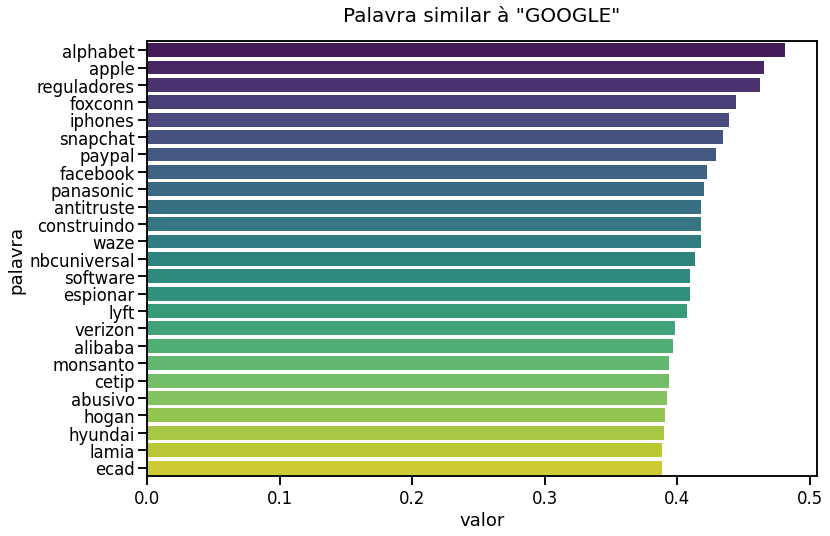

In [219]:

plt.figure(figsize=(12,8))
ax = sns.barplot(x='valor', y='palavra', data=google, palette='viridis')
#ax.set_xticklabels(google['palavra'], rotation=90)
plt.title(f'Palavra similar à "GOOGLE"', fontsize=20, pad=20)
ax;

## Fazendo operações com palavras

Dado que os parâmetros da função ``most_similar(self, positive=None, negative=None, topn=10, restrict_vocab=None, indexer=None)`` podemos passar uma lista de palavras "positivos" e uma lista de palavras "negativas", onde ele somará o contexto das positivas e retirará o contexto das negativas, por exemplo:

$$\text{PROFESSOR + MULHER - HOMEM = PROFESSORA},$$

acima foi somado o contexto da palavra professor mais o contexto da palavra mulher tirado o contexto da palavra homem.

In [220]:
w2v_modelo.wv.most_similar(positive=['professor', 'mulher'], negative=['homem'], topn=5)

[('girafales', 0.30833277106285095),
 ('professora', 0.2940760850906372),
 ('anunciada', 0.2938944399356842),
 ('vocação', 0.2888733148574829),
 ('referência', 0.2862910032272339)]